In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c jane-street-market-prediction

competition.cpython-37m-x86_64-linux-gnu.so: Skipping, found more recently modified local copy (use --force to force download)
__init__.py: Skipping, found more recently modified local copy (use --force to force download)
example_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
example_sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
features.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
"""
Reduce Memory Usage by 75%
https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day
"""

## Reduce Memory

def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
#                 reducing float16 for calculating numpy.nanmean
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df



In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 8.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=14f9483f440a81e375a7ffb58629431ff4156b913b0382606ef1d1b54131f65b
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=2e70bda9ad2dbfd57ee6269daa74c6a480c5bf152370a8e3090946c8f417381d
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import kerastuner as kt
from keras import layers
import tensorflow_addons as tfa

from kerastuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

import numpy as np
import pandas as pd
from random import choices
from tqdm import tqdm
import matplotlib.pyplot as plt

# import janestreet

In [ ]:
# Check GPU
!nvidia-smi

Wed Feb  3 19:11:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import pynvml

# pynvml.nvmlInit()
# handle = pynvml.nvmlDeviceGetHandleByIndex(0)
# device_name = pynvml.nvmlDeviceGetName(handle)

# if device_name != b'Tesla T4':
#   raise Exception("""
#     Unfortunately this instance does not have a T4 GPU.
    
#     Please make sure you've configured Colab to request a GPU instance type.
    
#     Sometimes Colab allocates a Tesla K80 instead of a T4. Resetting the instance.

#     If you get a K80 GPU, try Runtime -> Reset all runtimes...
#   """)
# else:
#   print('Woo! You got the right kind of GPU!')

In [ ]:
# # Install RAPIDS
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !bash rapidsai-csp-utils/colab/rapids-colab.sh

# import sys, os

# dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
# sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
# sys.path
# exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())


In [ ]:
# import cudf

In [ ]:
# %%time

# train = cudf.read_csv('train.csv')

In [ ]:
# def reduce_memory_usage(df):
train = pd.read_csv('train.csv')
train = reduce_memory_usage(train)

Memory usage of dataframe is 2516.843978881836 MB
Memory usage of dataframe after reduction 1247.0233011245728 MB
Reduced by 50.45289610369131 % 


In [ ]:
train.fillna(train.mean(),inplace=True)
train = train.query('weight > 0').reset_index(drop = True)

In [ ]:
train['action'] =  (  (train['resp_1'] > 0.00001 ) & (train['resp_2'] > 0.00001 ) & (train['resp_3'] > 0.00001 ) & (train['resp_4'] > 0.00001 ) &  (train['resp'] * train['weight'] > 0.001 )).astype('int')

In [ ]:
def lower_sample_data(df, percent=1):
    data1 = df[df['action'] == 1]
    data0 = df[df['action'] == 0]
    index = np.random.randint(len(data0), size=percent * (len(df) - len(data0))) #randomly pick the sample with action=0
    lower_data0 = data0.iloc[list(index)]
    return(pd.concat([lower_data0, data1]))

train = lower_sample_data(train)

In [ ]:
train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
865316,228,0.485024,0.006512,0.000428,-0.006964,-0.012145,-0.011132,-1,1.067063,1.758998,-0.946981,-1.056832,-1.151208,-1.385745,0.051773,0.026825,-0.278389,0.131507,-1.997445,-3.748260,-3.732770,-3.817390,-1.031656,-1.300626,0.121220,0.113582,-0.972639,-1.588603,-4.080263,-3.410172,-3.324315,-5.063827,-1.214634,-1.836943,0.135482,0.160878,0.908344,1.557845,0.372436,0.703770,...,-0.229309,-0.155368,-0.229395,-2.302408,0.402257,-1.338859,0.764688,0.856174,-1.194013,-1.198947,0.405025,-0.940190,0.109524,0.407665,-1.781693,-2.031842,0.399989,-0.902339,0.359242,0.483226,-1.289019,-1.840845,0.407116,-1.670158,-0.104203,0.149757,-2.056890,-1.555642,0.773427,2.109244,0.251341,0.383942,0.768659,2.323401,0.941635,1.463951,0.946444,1.395075,1078076,0
893211,235,2.176115,0.011735,0.009464,0.003452,-0.001319,0.003178,1,-0.114411,-0.717512,0.993715,0.656452,1.268570,0.929699,0.051773,0.026825,-0.099017,-0.502824,0.089116,0.049479,1.027177,0.426471,0.191417,-0.334537,0.121220,0.113582,1.340595,1.173040,0.186911,0.176981,1.995923,1.967844,1.761728,1.503628,0.135482,0.160878,-1.087858,-1.174936,0.220559,0.250122,...,0.404779,0.863946,-0.302553,-1.948853,0.402257,0.788332,0.406779,0.372027,0.425962,-1.695694,0.405025,1.999594,0.402193,1.764927,2.226700,-1.490595,0.399989,-0.623777,0.400732,0.002031,-0.699650,-2.677060,0.407116,1.130506,0.404427,1.860816,1.029689,-1.229184,0.335134,0.268782,-0.409049,0.356614,-0.345410,0.679605,-0.511296,0.452887,-0.373402,0.504219,1111263,0
1055679,278,0.181485,-0.002526,-0.000264,0.010809,0.025885,0.015172,1,-3.172026,-3.093182,0.405788,0.284262,-0.355784,-0.285833,0.051773,0.026825,-5.219111,-3.614536,3.137135,4.384707,5.083986,4.325328,-3.463443,-4.221748,0.121220,0.113582,0.426817,0.333303,5.340745,3.855617,5.346605,6.340704,0.448363,0.305265,0.135482,0.160878,-3.274225,-4.077749,-1.467694,-2.421895,...,-0.986136,-0.304707,0.012932,-3.696177,0.402257,1.175231,1.156861,1.844782,0.635880,-1.739762,0.405025,0.283076,0.207415,1.053692,-0.052598,-3.013555,0.399989,0.866758,0.351278,1.091217,0.489977,-2.867470,0.407116,-0.012478,-0.344630,0.713313,-0.435405,-2.362762,21.775967,25.966114,3.187879,2.451068,5.031921,6.229637,6.216775,4.706024,3.991561,2.738759,1303265,0
400986,85,1.805121,-0.012062,-0.022928,-0.056298,-0.111667,-0.085250,-1,-1.010386,-1.749416,-0.716776,-0.421528,-1.300052,-0.820254,0.051773,0.026825,0.840923,-0.144863,0.365274,-0.021438,1.317865,0.385957,1.137982,0.411316,0.121220,0.113582,-1.320409,-1.220728,-4.687186,-2.463820,-1.340741,-1.251441,-1.655838,-1.397531,0.135482,0.160878,2.008292,1.617754,1.587884,1.684338,...,-0.319131,-0.429792,0.305721,-2.446978,0.463773,-1.338859,0.345776,-1.257774,-1.194013,-1.380657,-0.448610,-0.940190,-0.301667,-1.510224,-1.781693,-2.482175,0.669280,0.353362,0.221968,-0.475836,-0.002227,-1.978619,-0.394305,-0.570486,-0.542444,-2.031889,-0.973060,-1.772838,2.656627,1.864221,2.852338,1.398268,2.378454,1.795895,3.597935,1.571765,3.414866,1.558767,515267,0
526749,124,4.917284,-0.000834,-0.000888,-0.001045,-0.000947,-0.000577,-1,1.993604,5.245586,-0.638016,-1.123263,0.075409,0.186832,0.124346,0.687342,0.951121,2.9164

In [ ]:
features = [c for c in train.columns if 'feature' in c]
X = train[['date'] + features]
y = train[['date', 'action']]

In [ ]:
X_train = X.loc[(X['date']>=0) & (X['date']<=462)][features].values
X_validation = X.loc[X['date']>462][features].values

y_train = y.loc[(y['date']>=0) & (y['date']<=462)]['action'].values
y_validation = y[y['date']>462]['action'].values

In [ ]:
X_train.shape

(889056, 130)

In [ ]:
model = Sequential()
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(320,input_shape = (X_train.shape[-1],),activation='relu',kernel_regularizer = 'l2'))
model.add(layers.Dropout(rate=0.236))
model.add(Dense(128,activation='relu'))
model.add(layers.Dropout(rate=0.231))
model.add(Dense(1312,activation='relu',kernel_regularizer="l2"))
model.add(layers.Dropout(rate=0.418))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train,
                    validation_data=(X_validation,y_validation),
                    batch_size=2048, epochs=350,
                   callbacks=[EarlyStopping('val_loss',patience=10,restore_best_weights=True)])

Epoch 1/350
435/435 [==============================] - 4s 7ms/step - loss: 1.3335 - accuracy: 0.5346 - val_loss: 0.6929 - val_accuracy: 0.5398
Epoch 2/350
435/435 [==============================] - 3s 6ms/step - loss: 0.6900 - accuracy: 0.5452 - val_loss: 0.6949 - val_accuracy: 0.5270
Epoch 3/350
435/435 [==============================] - 2s 6ms/step - loss: 0.6888 - accuracy: 0.5475 - val_loss: 0.6888 - val_accuracy: 0.5453
Epoch 4/350
435/435 [==============================] - 2s 6ms/step - loss: 0.6878 - accuracy: 0.5500 - val_loss: 0.6898 - val_accuracy: 0.5455
Epoch 5/350
435/435 [==============================] - 2s 6ms/step - loss: 0.6874 - accuracy: 0.5507 - val_loss: 0.6902 - val_accuracy: 0.5312
Epoch 6/350
435/435 [==============================] - 2s 6ms/step - loss: 0.6871 - accuracy: 0.5487 - val_loss: 0.6868 - val_accuracy: 0.5509
Epoch 7/350
435/435 [==============================] - 2s 6ms/step - loss: 0.6868 - accuracy: 0.5496 - val_loss: 0.6865 - val_accuracy: 0.5506

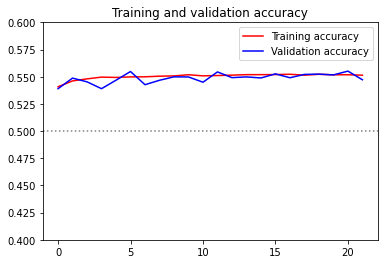

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(loss))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.axhline(y=0.5,ls=":",c="gray")
plt.title('Training and validation accuracy')
plt.legend()
plt.ylim(ymax=0.6,ymin=0.4)

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred = model.predict(X_validation)
print(classification_report(y_validation, pred.round(), labels=[True,False]))


              precision    recall  f1-score   support

        True       0.55      0.58      0.57     40454
       False       0.56      0.53      0.54     40722

    accuracy                           0.55     81176
   macro avg       0.55      0.55      0.55     81176
weighted avg       0.55      0.55      0.55     81176



1

In [ ]:
model = Sequential()
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(512,input_shape = (X_train.shape[-1],),activation='relu',kernel_regularizer = 'l2'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(256,activation='relu'))
model.add(layers.Dropout(rate=0.231))
model.add(Dense(1024,activation='relu',kernel_regularizer="l2"))
model.add(layers.Dropout(rate=0.5))
# model.add(Dense(2000,activation='relu',kernel_regularizer="l2"))
# model.add(layers.Dropout(rate=0.564))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train,
                    validation_data=(X_validation,y_validation),
                    batch_size=2048, epochs=350,
                   callbacks=[EarlyStopping('val_loss',patience=10,restore_best_weights=True)])

Epoch 1/350
435/435 [==============================] - 4s 7ms/step - loss: 1.8416 - accuracy: 0.5379 - val_loss: 0.6883 - val_accuracy: 0.5492
Epoch 2/350
435/435 [==============================] - 3s 6ms/step - loss: 0.6897 - accuracy: 0.5457 - val_loss: 0.6866 - val_accuracy: 0.5540
Epoch 3/350
435/435 [==============================] - 3s 6ms/step - loss: 0.6886 - accuracy: 0.5483 - val_loss: 0.6868 - val_accuracy: 0.5506
Epoch 4/350
435/435 [==============================] - 3s 6ms/step - loss: 0.6879 - accuracy: 0.5484 - val_loss: 0.6868 - val_accuracy: 0.5518
Epoch 5/350
435/435 [==============================] - 3s 6ms/step - loss: 0.6868 - accuracy: 0.5501 - val_loss: 0.6858 - val_accuracy: 0.5515
Epoch 6/350
435/435 [==============================] - 3s 6ms/step - loss: 0.6867 - accuracy: 0.5492 - val_loss: 0.6863 - val_accuracy: 0.5515
Epoch 7/350
435/435 [==============================] - 3s 6ms/step - loss: 0.6862 - accuracy: 0.5508 - val_loss: 0.6845 - val_accuracy: 0.5518

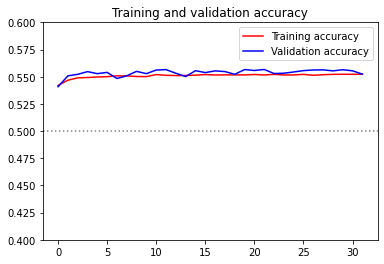

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(loss))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.axhline(y=0.5,ls=":",c="gray")
plt.title('Training and validation accuracy')
plt.legend()
plt.ylim(ymax=0.6,ymin=0.4)

plt.show()

In [ ]:
pred = model.predict(X_validation)
print(classification_report(y_validation, pred.round(), labels=[True,False]))

              precision    recall  f1-score   support

        True       0.55      0.60      0.57     40454
       False       0.56      0.51      0.54     40722

    accuracy                           0.56     81176
   macro avg       0.56      0.56      0.56     81176
weighted avg       0.56      0.56      0.56     81176



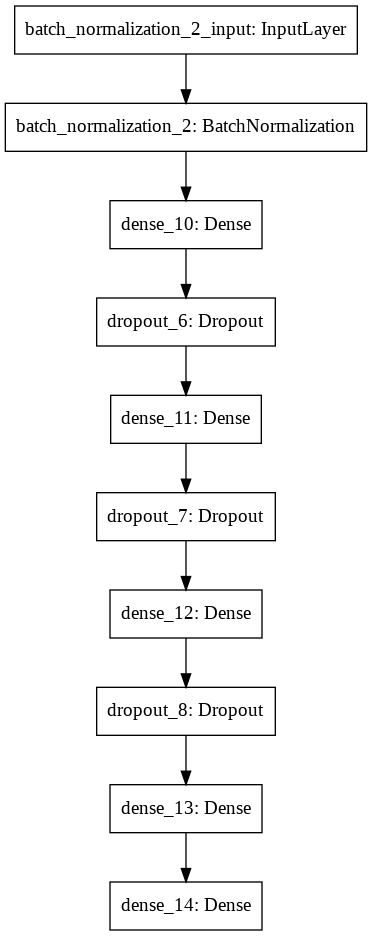

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model = Sequential()
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(512,input_shape = (X_train.shape[-1],),activation='relu',kernel_regularizer = 'l2'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(256,activation='swish'))
model.add(layers.Dropout(rate=0.231))
model.add(Dense(1024,activation='swish',kernel_regularizer="l2"))
model.add(layers.Dropout(rate=0.5))
# model.add(Dense(2000,activation='relu',kernel_regularizer="l2"))
# model.add(layers.Dropout(rate=0.564))
model.add(Dense(2))
model.add(Dense(1,activation='sigmoid'))

opt = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC'])
history = model.fit(X_train,y_train,
                    validation_data=(X_validation,y_validation),
                    batch_size=2048, epochs=350,
                   callbacks=[EarlyStopping('val_loss',patience=10,restore_best_weights=True)])

Epoch 1/350
435/435 [==============================] - 8s 12ms/step - loss: 4.4379 - auc: 0.5418 - val_loss: 0.7114 - val_auc: 0.5706
Epoch 2/350
435/435 [==============================] - 5s 12ms/step - loss: 0.6958 - auc: 0.5662 - val_loss: 0.6884 - val_auc: 0.5688
Epoch 3/350
435/435 [==============================] - 5s 11ms/step - loss: 0.6883 - auc: 0.5686 - val_loss: 0.6871 - val_auc: 0.5737
Epoch 4/350
435/435 [==============================] - 5s 11ms/step - loss: 0.6877 - auc: 0.5720 - val_loss: 0.6880 - val_auc: 0.5685
Epoch 5/350
435/435 [==============================] - 5s 11ms/step - loss: 0.6881 - auc: 0.5690 - val_loss: 0.6868 - val_auc: 0.5754
Epoch 6/350
435/435 [==============================] - 5s 12ms/step - loss: 0.6872 - auc: 0.5724 - val_loss: 0.6872 - val_auc: 0.5755
Epoch 7/350
435/435 [==============================] - 5s 12ms/step - loss: 0.6869 - auc: 0.5724 - val_loss: 0.6864 - val_auc: 0.5785
Epoch 8/350
435/435 [==============================] - 5s 11ms

In [ ]:
pred = model.predict(X_validation)
print(classification_report(y_validation, pred.round(), labels=[True,False]))

              precision    recall  f1-score   support

        True       0.56      0.53      0.54     40454
       False       0.56      0.59      0.57     40722

    accuracy                           0.56     81176
   macro avg       0.56      0.56      0.56     81176
weighted avg       0.56      0.56      0.56     81176



In [ ]:
model = Sequential()
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(512,input_shape = (X_train.shape[-1],),activation='relu',kernel_regularizer = 'l2'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(256,activation='swish'))
model.add(layers.Dropout(rate=0.231))
model.add(Dense(1024,activation='swish',kernel_regularizer="l2"))
model.add(layers.Dropout(rate=0.5))
# model.add(Dense(2000,activation='relu',kernel_regularizer="l2"))
# model.add(layers.Dropout(rate=0.564))
model.add(Dense(32, activation="relu"))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1))
model.add(layers.BatchNormalization())
model.add(layers.Activation("sigmoid"))

opt = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC'])
history = model.fit(X_train,y_train,
                    validation_data=(X_validation,y_validation),
                    batch_size=2048, epochs=350,
                   callbacks=[EarlyStopping('val_loss',patience=10,restore_best_weights=True)])

Epoch 1/350
435/435 [==============================] - 9s 15ms/step - loss: 4.7138 - auc: 0.5380 - val_loss: 0.7723 - val_auc: 0.5510
Epoch 2/350
435/435 [==============================] - 6s 14ms/step - loss: 0.7391 - auc: 0.5636 - val_loss: 0.7244 - val_auc: 0.5679
Epoch 3/350
435/435 [==============================] - 6s 14ms/step - loss: 0.7091 - auc: 0.5644 - val_loss: 0.7014 - val_auc: 0.5657
Epoch 4/350
435/435 [==============================] - 6s 14ms/step - loss: 0.7030 - auc: 0.5638 - val_loss: 0.6911 - val_auc: 0.5766
Epoch 5/350
435/435 [==============================] - 6s 14ms/step - loss: 0.6925 - auc: 0.5681 - val_loss: 0.6892 - val_auc: 0.5727
Epoch 6/350
435/435 [==============================] - 6s 14ms/step - loss: 0.6887 - auc: 0.5717 - val_loss: 0.6858 - val_auc: 0.5767
Epoch 7/350
435/435 [==============================] - 7s 15ms/step - loss: 0.6867 - auc: 0.5730 - val_loss: 0.6851 - val_auc: 0.5771
Epoch 8/350
435/435 [==============================] - 6s 14ms

In [ ]:
pred = model.predict(X_validation)
print(classification_report(y_validation, pred.round(), labels=[True,False]))

              precision    recall  f1-score   support

        True       0.56      0.53      0.54     40454
       False       0.56      0.58      0.57     40722

    accuracy                           0.56     81176
   macro avg       0.56      0.56      0.56     81176
weighted avg       0.56      0.56      0.56     81176



In [ ]:
model = Sequential()
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(320,input_shape = (X_train.shape[-1],),activation='relu',kernel_regularizer = 'l2'))
model.add(layers.Dropout(rate=0.236))
model.add(Dense(128,activation='relu'))
model.add(layers.Dropout(rate=0.231))
model.add(Dense(1312,activation='relu',kernel_regularizer="l2"))
model.add(layers.Dropout(rate=0.418))
model.add(Dense(32,activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1))
model.add(layers.BatchNormalization())
model.add(layers.Activation("sigmoid"))

opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train,
                    validation_data=(X_validation,y_validation),
                    batch_size=2048, epochs=350,
                   callbacks=[EarlyStopping('val_loss',patience=10,restore_best_weights=True)])

Epoch 1/350
435/435 [==============================] - 5s 8ms/step - loss: 1.4680 - accuracy: 0.5357 - val_loss: 0.7035 - val_accuracy: 0.5301
Epoch 2/350
435/435 [==============================] - 3s 7ms/step - loss: 0.7015 - accuracy: 0.5451 - val_loss: 0.6930 - val_accuracy: 0.5371
Epoch 3/350
435/435 [==============================] - 3s 7ms/step - loss: 0.6891 - accuracy: 0.5482 - val_loss: 0.6910 - val_accuracy: 0.5408
Epoch 4/350
435/435 [==============================] - 3s 7ms/step - loss: 0.6879 - accuracy: 0.5494 - val_loss: 0.6884 - val_accuracy: 0.5485
Epoch 5/350
435/435 [==============================] - 3s 7ms/step - loss: 0.6872 - accuracy: 0.5500 - val_loss: 0.6911 - val_accuracy: 0.5496
Epoch 6/350
435/435 [==============================] - 3s 8ms/step - loss: 0.6869 - accuracy: 0.5498 - val_loss: 0.6864 - val_accuracy: 0.5479
Epoch 7/350
435/435 [==============================] - 3s 7ms/step - loss: 0.6866 - accuracy: 0.5500 - val_loss: 0.6864 - val_accuracy: 0.5520

In [ ]:
pred = model.predict(X_validation)
print(classification_report(y_validation, predi(pred), labels=[True,False]))

              precision    recall  f1-score   support

        True       0.55      0.63      0.59     40454
       False       0.57      0.49      0.52     40722

    accuracy                           0.56     81176
   macro avg       0.56      0.56      0.56     81176
weighted avg       0.56      0.56      0.56     81176



In [ ]:
def predi(x):
  for i in range(len(x)):
    if x[i] >= 0.5:
      x[i] = 1
    else:
      x[i] = 0

  return x
  

In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Jane-Street-Market-Prediction')

In [ ]:
tuner.search_space_summary()


Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_validation,y_validation))

Trial 5 Complete [00h 19m 23s]
val_accuracy: 0.5016507506370544

Best val_accuracy So Far: 0.5594387451807658
Total elapsed time: 01h 49m 36s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/Jane-Street-Market-Prediction
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 19
units_0: 480
units_1: 96
learning_rate: 0.0001
units_2: 224
units_3: 480
units_4: 480
units_5: 32
units_6: 352
units_7: 96
units_8: 480
units_9: 192
units_10: 416
units_11: 480
units_12: 192
units_13: 384
units_14: 288
units_15: 256
units_16: 320
units_17: 320
units_18: 32
Score: 0.5594387451807658
Trial summary
Hyperparameters:
num_layers: 15
units_0: 64
units_1: 224
learning_rate: 0.0001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
Score: 0.5585107405980428
Trial summary
Hyperparameters:
num_layers: 5
units_0: 32
units_1: 384
learning_rate: 0.01
units_2: 480
units_3: 32
units_4: 160
units_5: 128
units_6: 416
units_7: 448
units_8: 480
units_9: 224
units_10: 416
units_11: 480
units_12: 192
uni

In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Dense(units = hp.Int("Input Layer", min_value=32, max_value=512),input_shape = (X_train.shape[-1],),activation='relu',kernel_regularizer = 'l2'))
    model.add(layers.Dropout(rate=hp.Float("Drop Out Input", 0.1, 0.5, 0.1)))
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
        model.add(layers.Dropout(rate=hp.Float("Drop Out " + str(i), 0.1, 0.5, 0.1)))
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(1))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner2 = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project2',
    project_name='Jane-Street-Market-Prediction')

In [ ]:
tuner.search_space_summary()


Search space summary
Default search space size: 21
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

In [ ]:
tuner2.search(X_train, y_train,
             epochs=5,
             validation_data=(X_validation,y_validation))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
Input Layer       |157               |?                 
Drop Out Input    |0.1               |?                 
num_layers        |19                |?                 
units_0           |96                |?                 
Drop Out 0        |0.1               |?                 
units_1           |224               |?                 
Drop Out 1        |0.1               |?                 
learning_rate     |0.001             |?                 

Epoch 1/5
27783/27783 [==============================] - 306s 11ms/step - loss: 1.1447 - accuracy: 0.5022 - val_loss: 0.7032 - val_accuracy: 0.5190
Epoch 2/5
27783/27783 [==============================] - 300s 11ms/step - loss: 0.7030 - accuracy: 0.5163 - val_loss: 0.6970 - val_accuracy: 0.5107
Epoch 3/5
27783/27783 [==============================] - 298s 11ms/step - loss: 0.6991 - accuracy: 0.5178 - val_loss: 0.7025 - val_accuracy: 0.5089
Epoch 4/5
27783